# Notebook - long with show cases

In [28]:
# required libraries
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math
import scipy
import itertools


In [175]:
# definitions of fundamental constant used in calculations
# physics constants
hbar = scipy.constants.hbar
h = scipy.constants.h
pi = math.pi
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
_1eV  = scipy.constants.physical_constants["electron volt"][0]

m_eff = 0.067 # [* m_0] GaAs

# Deffinition of the computational box
site_size = 500 # [Angstrom]

# Number of atoms per site in material
site_elements = 30 # elements
n = site_elements

#
# Fundamental values of the grid
#
def t_calc(
        a,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    return 1 / (2 * m_eff * a ** 2) * (hbar ** 2) / (m_0 * 10e-20 * _1eV)   # [eV]

def a_calc(
        site_size,
        site_elements
):
    return site_size / (site_elements - 1) # [Angstrom] - distance between elements 

site_size = 500
site_elements = 30
PBC = True
V_max = 0.1 
r_0 = 150
m_eff = 0.067
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar = scipy.constants.hbar
_1eV = scipy.constants.physical_constants["electron volt"][0]
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)


## 1D dispersion
data:
- ek_kp_1D
- ek_cos_1D


In [30]:
kx = np.linspace(-pi/a,pi/a,n)
# kp dispersion
E0 = 0
f = lambda kx: (hbar ** 2) * (kx ** 2) / (2 * m_eff * m_0 * _1eV * 10e-20) + E0
ek_kp_1D = np.array(list(map(f, kx))) # in eV

# cos dispersion
dEs = 0
# t = 1 / (2 * m_eff * a ** 2) * (hbar ** 2) / (m_0 * 10e-20 * _1eV)   # [eV]
ek_cos_1D = dEs - 2 * t * np.cos(kx * a) # in eV

# scale the ek_cos_1D so it will start at 0
f = lambda x: x - delta
delta = np.amin(ek_cos_1D)
ek_cos_1D = np.array(list(map(f, ek_cos_1D)))

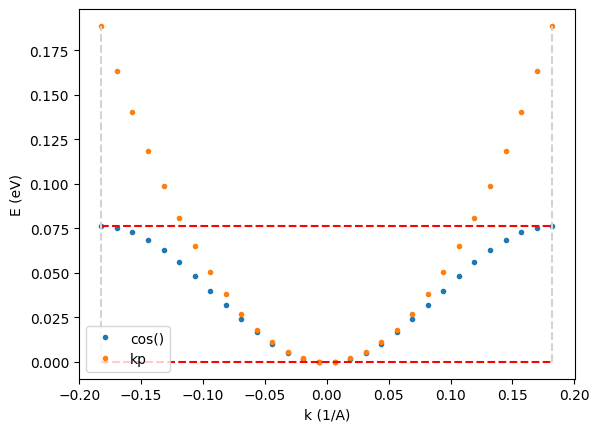

In [33]:
# Ploting dispersion 1D
plt.plot(kx,ek_cos_1D,'.', label="cos()")
plt.plot(kx,ek_kp_1D,'.', label="kp")
plt.xlabel("k (1/A)")
plt.ylabel("E (eV)")
plt.hlines(4*t, -pi/a, pi/a, colors="red", linestyles="--")
plt.hlines(0, -pi/a, pi/a, colors="red", linestyles="--")
plt.vlines(-pi/a, 0, np.amax(ek_kp_1D), colors="lightgray", linestyles="--")
plt.vlines(pi/a, 0, np.amax(ek_kp_1D), colors="lightgray", linestyles="--")
plt.legend()
plt.show()

## 2D dispersion
data:
- ek_kp
- ek_cos

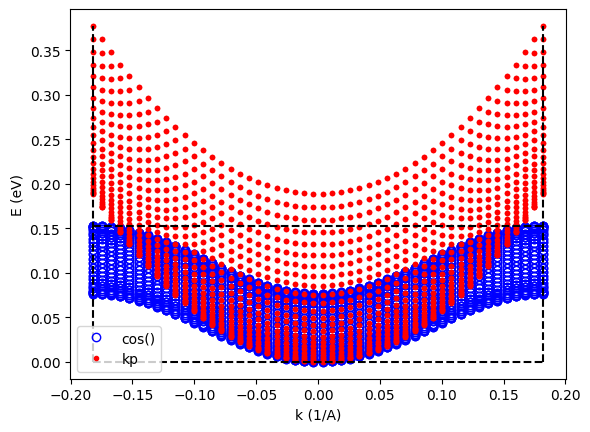

In [34]:
#
# Dispersion 2D
#
def dispersion_2D(
    site_elements,
    t,
    a,
    hbar,
    m_eff, 
    m_0,
    _1eV,
    E0,
    dEs):

    kx = np.linspace(-pi/a,pi/a,site_elements)
    ky = np.linspace(-pi/a,pi/a,site_elements)
    kxx, kyy = np.meshgrid(kx, ky)
    dEs = 0

    # kp
    f = lambda kx, ky: (hbar ** 2) * (kx ** 2 + ky ** 2) / (2 * m_eff * m_0 * _1eV * 10e-20) + E0
    ek_kp = np.array(list(map(f, kxx, kyy)))


    # cos
    ek_cos = dEs - 2 * t * (np.cos(kxx * a) + np.cos(kyy * a))

    # scale the ek_cos so it will start at 0
    f = lambda x: x - delta
    delta = np.amin(ek_cos)
    ek_cos = np.array(list(map(f, ek_cos)))

    # plot dispersion
    plt.plot(kx,ek_cos[0],'o', mfc = 'none', mec = 'blue', color="blue", label="cos()")
    for i in range(1,site_elements):
        plt.plot(kx,ek_cos[i],'o', mfc = 'none', mec = 'blue', color="blue")
    plt.plot(kx,ek_kp[0],'.', color="red", label="kp")
    for i in range(1,site_elements):    
        plt.plot(kx,ek_kp[i],'.', color="red")
    plt.xlabel("k (1/A)")
    plt.ylabel("E (eV)")
    plt.hlines(8*t, -pi/a, pi/a, colors="black", linestyles="--")
    plt.hlines(0, -pi/a, pi/a, colors="black", linestyles="--")
    plt.vlines(-pi/a, 0, np.amax(ek_kp), colors="black", linestyles="--")
    plt.vlines(pi/a, 0, np.amax(ek_kp), colors="black", linestyles="--")
    plt.legend()
    plt.show()

dispersion_2D(
    site_elements=50,
    t=t,
    a=a,
    hbar=hbar,
    m_eff=m_eff, 
    m_0=m_0,
    _1eV=_1eV,
    E0=0,
    dEs=0)

sieciowa regularyzacja - tw. neomi regul. ferm ferm-dirac

## Layout

In [172]:
#
# Layout
#
def initialize_layout(site_elements, a):
    Layout = {"2Dneighbours": np.zeros((site_elements, site_elements), dtype=int),
              "realLocation": [[[]]]}
    k = 1
    for i in range(site_elements):
        for j in range(site_elements):
            Layout["2Dneighbours"][j][i] = k
            Layout["realLocation"].append([k,[a*i,a*j]])
            k += 1
    Layout["realLocation"] = Layout["realLocation"][1:]

    return Layout

def plot_layout(Layout):
    X = np.zeros(len(Layout["realLocation"]))
    Y = np.zeros(len(Layout["realLocation"]))
    for i in range(len(Layout["realLocation"])):
        elem = Layout["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]
    plt.scatter(X, Y, c='blue', linewidths=1)

    plt.gca().set_aspect('equal', 'box')
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.show()   

   

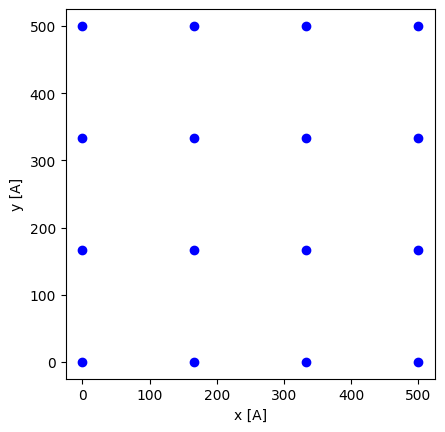

In [178]:
# show layout showcase

Layout = initialize_layout(site_elements, a)
#print(Layout)
plot_layout(Layout)

In [180]:
def initialize_hamiltonian(Layout, t, PBC:bool, V_max, r_0):
    site_elements = Layout["2Dneighbours"].shape[0]
    elements = site_elements**2
    Hamiltonian = np.zeros((elements,elements))
    
    for i in range(site_elements):
        for j in range(site_elements):
            elem = Layout["2Dneighbours"][i,j] - 1

            next_x, prev_x, next_y, prev_y = neighbours(Layout["2Dneighbours"], i, j, PBC)

            if next_x in range(elements):
                Hamiltonian[next_x,elem] = -t
                Hamiltonian[elem,next_x] = -t

            if prev_x in range(elements):    
                Hamiltonian[prev_x,elem] = -t
                Hamiltonian[elem,prev_x] = -t

            if next_y in range(elements):
                Hamiltonian[next_y,elem] = -t
                Hamiltonian[elem,next_y] = -t
            
            if prev_y in range(elements):
                Hamiltonian[prev_y,elem] = -t
                Hamiltonian[elem,prev_y] = -t

    for i in range(elements):

       Hamiltonian[i][i] = 4*t
       
    return Hamiltonian


def neighbours(Layout, i, j, PBC:bool):
    site_elements = Layout.shape[0]
    if PBC:
        #print("PBC True")
        if j in range(1,site_elements-1):
            next_y = j + 1
            prev_y = j - 1
        elif j == 0:
            next_y = j + 1
            prev_y = site_elements-1
        else:
            next_y = 0
            prev_y = j - 1

        if i in range(1,site_elements-1):
            next_x = i + 1
            prev_x = i - 1
        elif i == 0:
            next_x = i + 1
            prev_x = site_elements-1
        else:
            next_x = 0
            prev_x = i - 1
        
        return Layout[next_x,j]-1, Layout[prev_x,j]-1, Layout[i,next_y]-1, Layout[i,prev_y]-1 
    else:
        next_y = j + 1
        prev_y = j - 1
        next_x = i + 1
        prev_x = i - 1

        if prev_y in range(0,site_elements):
            prev_y_elem = Layout[i,prev_y]-1 
        else:
            prev_y_elem = -1
        if next_y in range(0,site_elements):
            next_y_elem = Layout[i,next_y]-1
        else:
            next_y_elem = -1
        if prev_x in range(0,site_elements):
            prev_x_elem =  Layout[prev_x,j]-1
        else:
            prev_x_elem = -1
        if next_x in range(0,site_elements):
            next_x_elem =  Layout[next_x,j]-1
        else:
            next_x_elem = -1

        return next_x_elem, prev_x_elem, next_y_elem, prev_y_elem 

def diagonalize_hamiltonian(Hamiltonian):
    E,psiT = np.linalg.eigh(Hamiltonian) # This computes the eigen values and eigenvectors
    psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
    #plt.plot(E, 'o')
    #plt.show()
    return E

def show_hamiltonian(Hamiltonian):
    Hamiltonian = np.flip(Hamiltonian,axis=1)
    ran = math.floor(math.sqrt(Hamiltonian.size))
    fig, ax = plt.subplots()
    pcm = ax.imshow(Hamiltonian, cmap='hot', extent=[0, ran, 0, ran])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.invert_yaxis()
    ax.xaxis.set_label_position('top')
    fig.colorbar(pcm, ax=ax)
    plt.show()

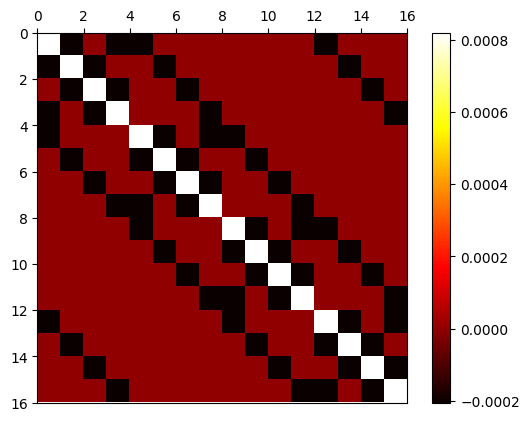

In [184]:
Layout = initialize_layout(4, a)
Hamiltonian = initialize_hamiltonian(Layout, t, True, V_max, r_0)

show_hamiltonian(Hamiltonian)


### Solving this Hamiltonian

In [214]:
def plot_eigenvalues_hamiltonian_whole(diagonalizated_hamiltonain, t):
    plt.plot(diagonalizated_hamiltonain, '.')
    #bottom = np.amin(diagonalizated_hamiltonain)
    plt.hlines(8*t, 0, len(diagonalizated_hamiltonain), colors="red", linestyles="--")
    plt.hlines(0, 0, len(diagonalizated_hamiltonain), colors="red", linestyles="--")
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.show()

def plot_eigenvalues_hamiltonian(diagonalizated_hamiltonain):
    plt.plot(diagonalizated_hamiltonain, 'o')
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.show()

def plot_multiple_eigenvalues_hamiltonian(diagonalizated_hamiltonain_list, label_list, plot_first):
    i=0
    for diagH in diagonalizated_hamiltonain_list:
        plt.plot(diagH[:plot_first], 'o', label=label_list[i])
        i+=1
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.legend()
    plt.show()

def eigenvalues_hamiltonian(
        site_size,
        site_elements,
        PBC:bool,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    a = a_calc(site_size=site_size, site_elements=site_elements)
    t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    Layout = initialize_layout(site_elements, a)
    Hamiltonian = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
    return diagonalize_hamiltonian(Hamiltonian)


site_size = 500
site_elements = 10
PBC = False
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)

#Layout = initialize_layout(site_elements, a)
#Hamiltonian = initialize_hamiltonian(Layout, t, PBC)
#diagonalizated_hamiltonain = diagonalize_hamiltonian(Hamiltonian)

#plot_eigenvalues_hamiltonian_whole(diagonalizated_hamiltonain, t)

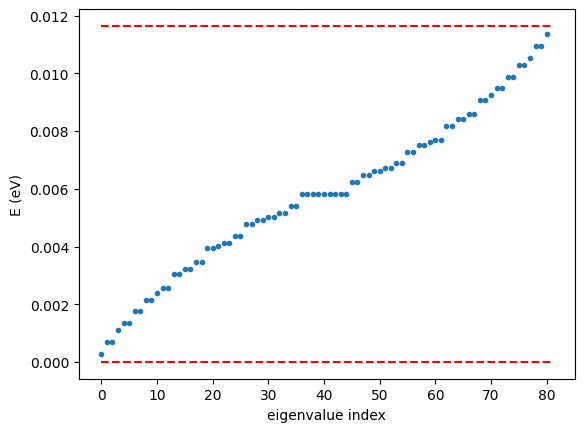

In [218]:
site_size = 500
site_elements = 50
PBC = True
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)

site_size = 500
site_elements = 9
PBC = False
V_max = 0
r_0 = 150
m_eff = 0.067
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar = scipy.constants.hbar
_1eV = scipy.constants.physical_constants["electron volt"][0]
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)


Layout = initialize_layout(site_elements, a)
Hamiltonian = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
diagonalizated_hamiltonain = diagonalize_hamiltonian(Hamiltonian)

plot_eigenvalues_hamiltonian_whole(diagonalizated_hamiltonain, t)


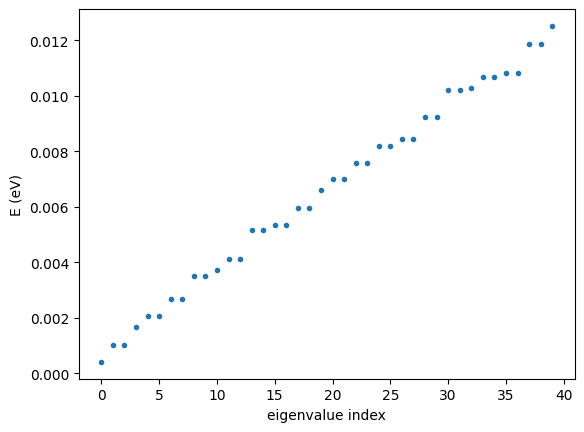

In [193]:
plt.plot(diagonalizated_hamiltonain[:40], '.')
bottom = np.amin(diagonalizated_hamiltonain)
plt.xlabel("eigenvalue index")
plt.ylabel("E (eV)")
plt.show()

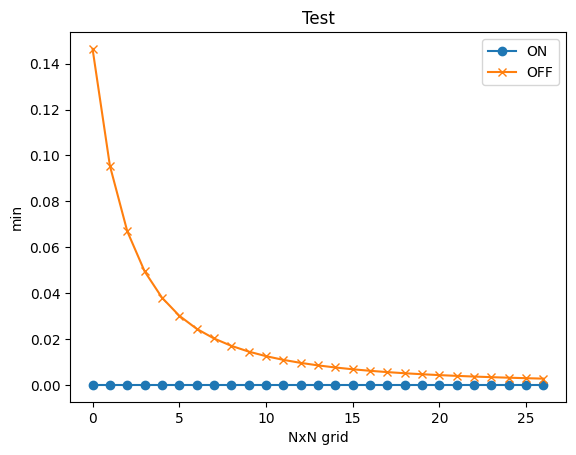

<Figure size 640x480 with 0 Axes>

In [219]:
# zbieżność do 0 w zależności od rozmiaru
def convergence_test(
        start_test_size,
        stop_test_size,
        site_size,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    ON_PBC = np.zeros(stop_test_size-start_test_size)
    OFF_PBC = np.zeros(stop_test_size-start_test_size)


    for i in range(start_test_size,stop_test_size):
        a = a_calc(site_size=site_size, site_elements=i)
        t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)

        PBC = True
        ON = eigenvalues_hamiltonian(site_size=site_size, site_elements=i, PBC=PBC, V_max=V_max, r_0=r_0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        ON_PBC[i-start_test_size] = ON[0] / (8*t) # (8 * t - (ON[len(ON)-1] - ON[0])) / (8 * t) * 100

        PBC = False
        OFF = eigenvalues_hamiltonian(site_size=site_size, site_elements=i, PBC=PBC, V_max=V_max, r_0=r_0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        OFF_PBC[i-start_test_size] = np.amin(OFF)/ (8*t) # (8 * t - (OFF[len(OFF)-1] - OFF[0])) / (8 * t) * 100

    plt.plot(ON_PBC, "-o", label="ON")
    plt.plot(OFF_PBC, "-x", label="OFF")
    plt.title("Test")
    plt.xlabel("NxN grid")
    plt.ylabel("min")
    #plt.ylabel("diference / theoretical (%)")
    plt.legend()
    plt.show()
    plt.clf()
    
convergence_test(
        start_test_size=3,
        stop_test_size=30,
        site_size=500,
        V_max=0, 
        r_0=0, 
        m_eff=m_eff,
        m_0=m_0,
        hbar=hbar,
        _1eV=_1eV
)

### V(x,y)

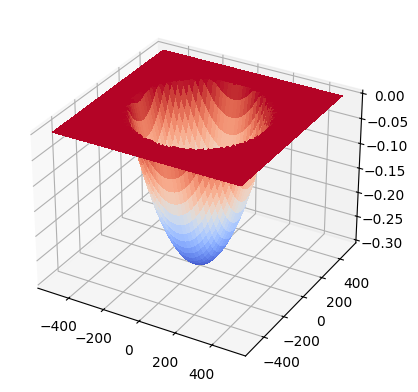

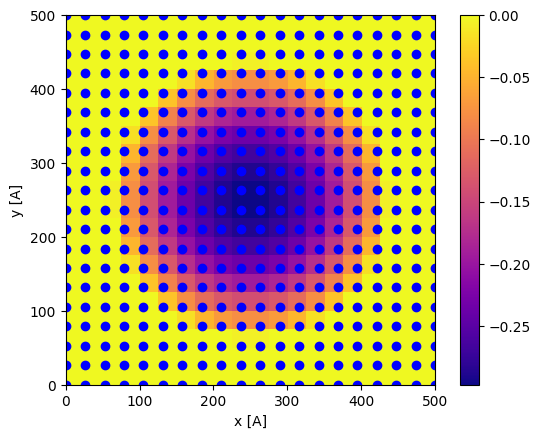

In [199]:
#
# Potential
#
def V(i, Layout, V_max, r_0):
    dist_sqr = distance_sqr_from_center(i, Layout)
    return V_n_direct(dist_sqr, V_max, r_0)

def V_n_direct(dist_sqr, V_max, r_0):
    dist_sqr = abs(dist_sqr)
    if np.sqrt(dist_sqr) >= r_0:
        return 0
    else:
        return V_max/(r_0*r_0) * dist_sqr - V_max

def distance_sqr_from_center(elem1, Layout):
    site_size = Layout["realLocation"][len(Layout["realLocation"])-1][1][0]
    center = site_size/2
    #for p_elem in Layout["realLocation"]:
    #    if elem1 == p_elem[0]:
    #        x1, y1 = p_elem[1][0], p_elem[1][1]
    x1, y1 = Layout["realLocation"][elem1-1][1][0], Layout["realLocation"][elem1-1][1][1]
    return (x1 - center)**2 + (y1 - center)**2

def plot_potential_on_grid(Layout_base, site_size, site_elements, V_max, r_0):
    a = a_calc(site_size, site_elements)
    Layout = initialize_layout(site_elements, a)

    Potencial = np.zeros_like(Layout["2Dneighbours"], dtype=float)
    for i in range(site_elements):
        for j in range(site_elements):
            Potencial[j,i] = V((i*site_elements+j+1), Layout, V_max, r_0)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]

    plt.scatter(X, Y, c='blue', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.imshow(Potencial, cmap=cm.plasma, extent = [0, site_size, 0, site_size])
    plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.show()


def potential_3D(site_elements, a, V_max, r_0):
    def V_n_direct(dist_sqr, V_max, r_0):
        dist_sqr = abs(dist_sqr)
        if np.sqrt(dist_sqr) >= r_0:
            #print(dist_sqr, 0)
            return 0
        else:
            #print(dist_sqr, V_max/(r_0*r_0) * dist_sqr - V_max)
            return V_max/(r_0*r_0) * dist_sqr - V_max

    def V_n(dist_sqr, V_max, r_0):
        dist_sqr = dist_sqr
        a_help = np.zeros_like(dist_sqr)
        for i in range(len(dist_sqr)):
            a_help[i] = V_n_direct(dist_sqr[i], V_max, r_0)
        return a_help
    
    x = np.linspace(-site_elements*a,site_elements*a,site_elements)
    y = np.linspace(-site_elements*a,site_elements*a,site_elements) 
    xx, yy = np.meshgrid(x, y)

    R = ((a*xx)**2 + (a*yy)**2)

    f = lambda R, V_max, r_0: V_n(R, V_max, r_0)
    Potencial = np.array(list(map(f, R, np.full(len(R), V_max), np.full(len(R), r_0))))

    # show all Potencial
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, Potencial, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
    plt.show()
    plt.clf()

site_size=500
site_elements=100
a=a_calc(site_size, site_elements)
V_max=0.3
r_0=200
potential_3D(site_elements=site_elements, a=a, V_max=0.3, r_0=1750)

site_elements = 20
Layout_base = initialize_layout(site_elements, a=a_calc(site_size, site_elements))
plot_potential_on_grid(Layout_base, site_size, site_elements=20, V_max=V_max, r_0=r_0)


### Hamiltonian with the potencial

In [204]:
#
# Hamiltonian
#
def initialize_hamiltonian(Layout, t, PBC:bool, V_max, r_0):
    site_elements = Layout["2Dneighbours"].shape[0]
    elements = site_elements**2
    Hamiltonian = np.zeros((elements,elements))
    
    for i in range(site_elements):
        for j in range(site_elements):
            elem = Layout["2Dneighbours"][i,j] - 1

            next_x, prev_x, next_y, prev_y = neighbours(Layout["2Dneighbours"], i, j, PBC)

            if next_x in range(elements):
                Hamiltonian[next_x,elem] = -t
                Hamiltonian[elem,next_x] = -t

            if prev_x in range(elements):    
                Hamiltonian[prev_x,elem] = -t
                Hamiltonian[elem,prev_x] = -t

            if next_y in range(elements):
                Hamiltonian[next_y,elem] = -t
                Hamiltonian[elem,next_y] = -t
            
            if prev_y in range(elements):
                Hamiltonian[prev_y,elem] = -t
                Hamiltonian[elem,prev_y] = -t

    for i in range(elements):

       Hamiltonian[i][i] = 4*t + V(i+1, Layout, V_max, r_0)
       
    return Hamiltonian

In [ ]:
Layout 

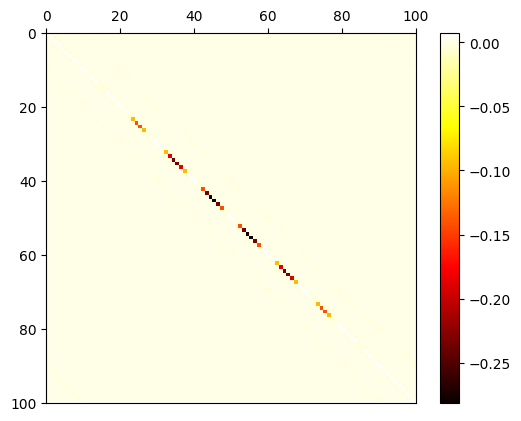

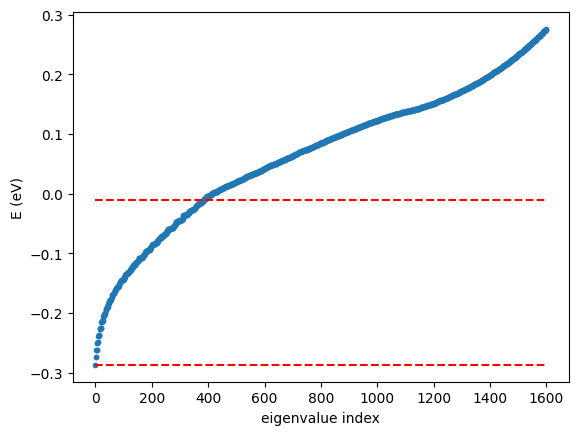

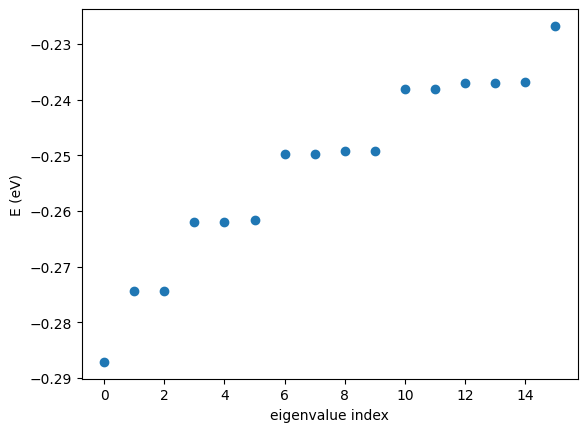

In [208]:
site_size = 500
PBC = True
V_max = 0.3 
r_0 = 200
7
site_elements = 10
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)

Layout = initialize_layout(site_elements, a)
Hamiltonian = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
show_hamiltonian(Hamiltonian)

site_elements = 40
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)
Layout = initialize_layout(site_elements, a)
Hamiltonian = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
diagHamiltonian = diagonalize_hamiltonian(Hamiltonian)
plot_eigenvalues_hamiltonian_whole(diagHamiltonian, t)
plot_eigenvalues_hamiltonian(diagHamiltonian[:16])


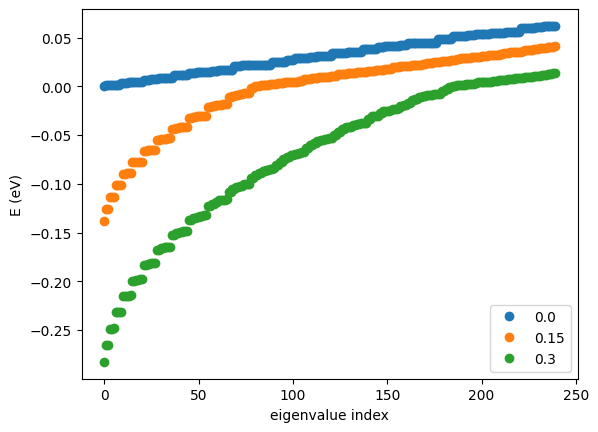

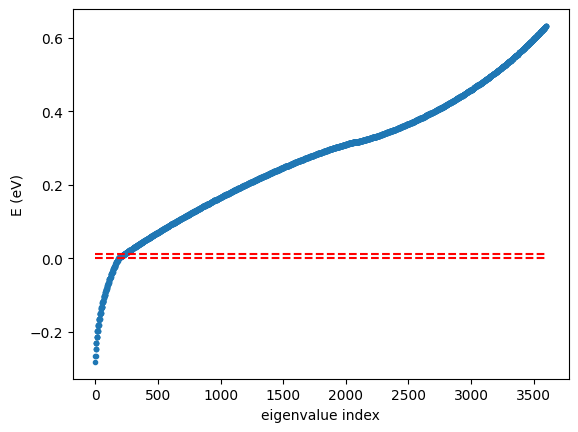

In [220]:
elements_list = [0.0, 0.15, 0.3]
ham_list = []
idx = 0 
for i in elements_list:
    ham_list.append(eigenvalues_hamiltonian(
            site_size=500,
            site_elements=60,
            PBC=True,
            V_max=i, 
            r_0=150,
            m_eff=m_eff,
            m_0=m_0,
            hbar=hbar,
            _1eV=_1eV
    ))
    idx+=1
ham_list = ham_list[0:]

plot_multiple_eigenvalues_hamiltonian(ham_list, elements_list, 240)
plot_eigenvalues_hamiltonian_whole(ham_list[2],t)

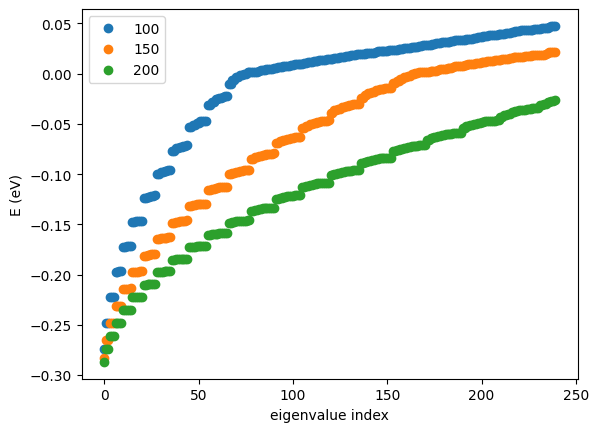

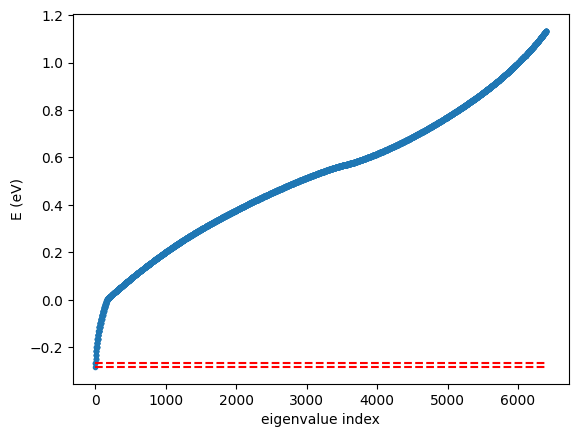

In [169]:
elements_list = [100, 150, 200]
ham_list = []
idx = 0 
for i in elements_list:
    ham_list.append(eigenvalues_hamiltonian(
            site_size=500,
            site_elements=60,
            PBC=True,
            V_max=0.3, 
            r_0=i,
            m_eff=m_eff,
            m_0=m_0,
            hbar=hbar,
            _1eV=_1eV
    ))
    idx+=1
ham_list = ham_list[0:]

plot_multiple_eigenvalues_hamiltonian(ham_list, elements_list, 240)
plot_eigenvalues_hamiltonian_whole(ham_list[1],t)

In [170]:
elements_list = [27, 40, 60, 80]

ham_list = []
idx = 0 
for i in elements_list:
    ham_list.append(eigenvalues_hamiltonian(
            site_size=site_size,
            site_elements=i,
            PBC=PBC,
            V_max=V_max, 
            r_0=r_0,
            m_eff=m_eff,
            m_0=m_0,
            hbar=hbar,
            _1eV=_1eV
    ))
    idx+=1
ham_list = ham_list[0:]

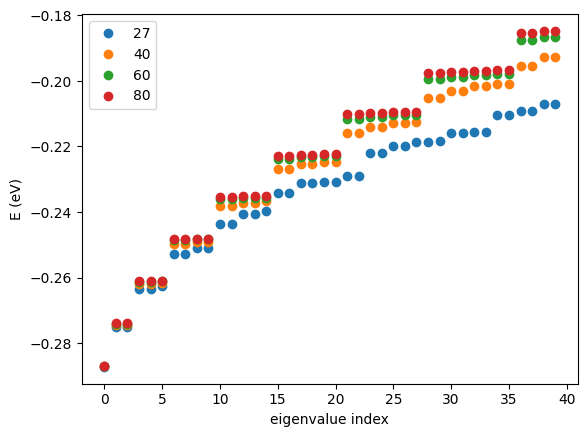

In [171]:
plot_multiple_eigenvalues_hamiltonian(ham_list,["27","40","60", "80"], 40)

In [ ]:

ran = math.floor(math.sqrt(Hamiltonian.size))
plt.imshow(Hamiltonian, cmap='hot', extent=[0, ran, 0, ran])
plt.colorbar() 
plt.show()

aaa = np.zeros(ran)
for i in range(ran):
    aaa[i] = Hamiltonian[i][i]
plt.clf()
plt.plot(aaa, ".")
plt.xlabel("i-ty element na diagonali Hamiltonianu")
plt.ylabel("Wartość i-tego elementu")
plt.show()

diagonalizated_hamiltonain = diagonalize_hamiltonian(Hamiltonian)

plt.plot(diagonalizated_hamiltonain, 'o')
bottom = np.amin(diagonalizated_hamiltonain)
plt.hlines(8*t+bottom, 0, len(diagonalizated_hamiltonain), colors="lightgray", linestyles="--")
plt.hlines(bottom, 0, len(diagonalizated_hamiltonain), colors="lightgray", linestyles="--")
plt.xlabel("eigenvalue index")
plt.ylabel("E (eV)")
plt.show()

plt.plot(diagonalizated_hamiltonain[:60], 'o')
plt.xlabel("eigenvalue index")
plt.ylabel("E (eV)")
plt.show()

In [ ]:
def omega_calc(V, r):
    return np.sqrt((2*V*_1eV)/(r*10e-10)**2)

omega = omega_calc(V_max, r_0)
calculation = diagonalizated_hamiltonain[1]-diagonalizated_hamiltonain[0]
print(omega, calculation, omega - calculation, abs(omega - calculation)/omega*100, a, _1eV, V_max, r_0)

0.007751233693741919 0.006483406318969376 0.0012678273747725429 16.35645917624885 1 1.602176634e-19 0.3 40
